In [5]:
import pandas as pd
from definitions import Cell_types_displayed_Danenberg
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("./..")
from soft_wl_subtree import Soft_WL_Subtree

### Load fitted soft wl subtree kernel

In [16]:
if os.path.exists("fitted_soft_wl_subtree.pkl"):
    print("There is a pre-fitted soft wl subtree kernel. We will load it directly.")
    with open("fitted_soft_wl_subtree.pkl", "rb") as f:
        soft_wl_subtree_ = pickle.load(f)
else:
    print("There is no pre-fitted soft wl subtree kernel.")
    print("Go run `python 3_fit_wl_subtree_kernel.py` instead")


There is a pre-fitted soft wl subtree kernel. We will load it directly.


### Visualize the Signature map

In [4]:
Signatures = soft_wl_subtree_.Signatures
Histograms = soft_wl_subtree_.Histograms
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)
# Proportion of each pattern presented in each patient's cellular graphs
DF_proportion = pd.DataFrame({})
index = 0
for i in range(Proportions.shape[0]):
    for j in range(Proportions.shape[1]):
        DF_proportion.loc[index, 'pattern_id'] = str(j)
        DF_proportion.loc[index, 'proportion'] = Proportions[i, j]
        index += 1

#### 1) Default order (sorted by pattern cluster size, descendent)

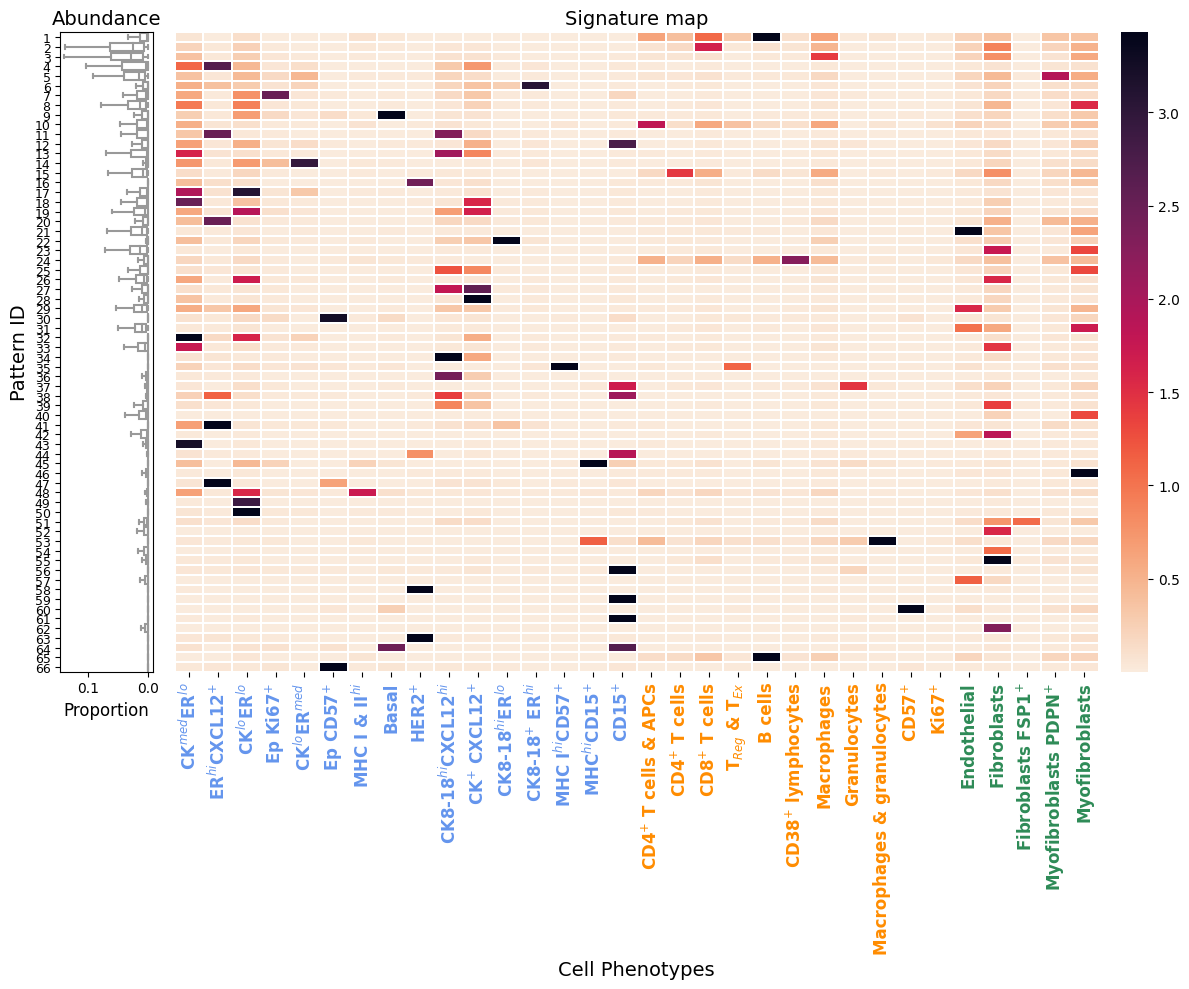

In [5]:

f, ax = plt.subplots(
    1,
    3,
    figsize=(12, 10),
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 10, 0.3]},
)
sns.heatmap(
    Signatures,
    ax=ax[1],
    cmap="rocket_r",
    linewidth=0.005,
    cbar=True,
    cbar_ax=ax[2],
    edgecolor="black",
    vmax=np.percentile(Signatures, 99),
    vmin=np.percentile(Signatures, 5),
)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Signature map", fontsize=14)
ax[1].set_xticklabels(
    Cell_types_displayed_Danenberg, rotation=90, fontsize=12, fontweight="bold"
)
ax[1].set_xlabel("Cell Phenotypes", fontsize=14)
xtickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["seagreen"] * 5
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[2].get_xaxis().set_visible(False)

sns.boxplot(
    y="pattern_id",
    x="proportion",
    data=DF_proportion,
    showfliers=False,
    ax=ax[0],
    color="white",
    order=[str(i) for i in range(Signatures.shape[0])],
    fliersize=0.5,
)
ax[0].set_xlabel("Proportion", fontsize=12)
ax[0].set_title("Abundance", fontsize=14)
ax[0].set_yticklabels([i + 1 for i in range(Signatures.shape[0])], fontsize=9)
ax[0].set_ylabel("Pattern ID", fontsize=14)
ax[0].invert_xaxis()
plt.show()

#### 2) Reordered: gathered tme patterns by tumor niches, immune niches, stromal niches, and interfacing niches (Only for visualization purpose)

In [6]:
# Define tumor niches, immune niches, stromal niches, and interfacing niches
threshold = 0.5  # does not impact the downstream analysis, only imapct the presentation of the signature map
tumor_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 16:] > threshold, axis=1) == 0)
)[0]
immune_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) == 0)
)[0]
stromal_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) > 0)
)[0]
interacting_niche = [
    i
    for i in range(Signatures.shape[0])
    if i not in np.concatenate([tumor_niche, immune_niche, stromal_niche])
]
print("There are {} identified TME patterns.".format(Signatures.shape[0]))
print(
    "There are {} tumor niches, {} immune niches, {} stromal niches, and {} interacting niches.".format(
        len(tumor_niche), len(immune_niche), len(stromal_niche), len(interacting_niche)
    )
)

There are 66 identified TME patterns.
There are 35 tumor niches, 4 immune niches, 13 stromal niches, and 14 interacting niches.


#### Fig. 4 Abundance and Signature map of TME patterns.

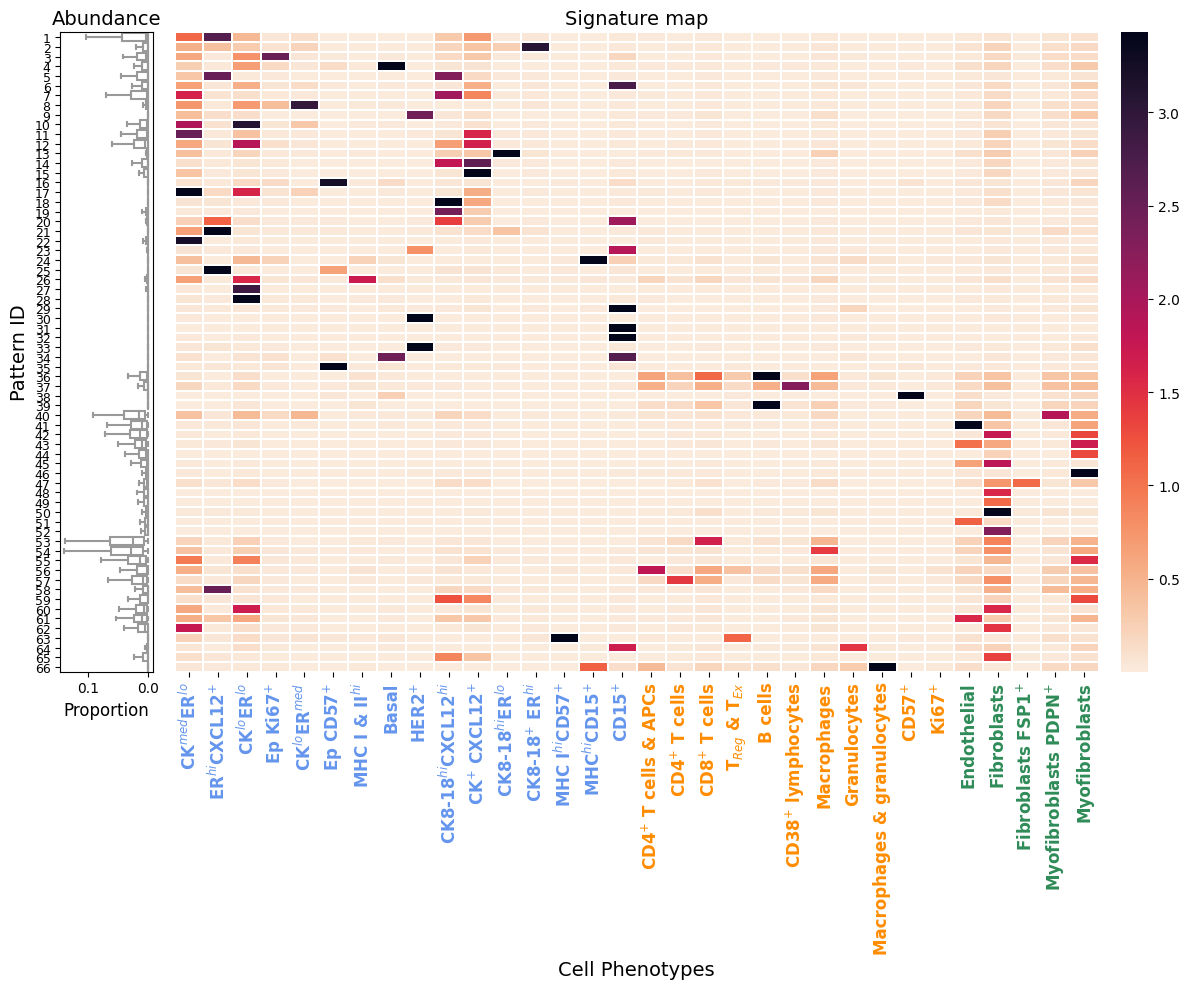

In [7]:
f, ax = plt.subplots(
    1,
    3,
    figsize=(12, 10),
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 10, 0.3]},
)
Indices = np.concatenate([tumor_niche, immune_niche, stromal_niche, interacting_niche])
sns.heatmap(
    Signatures[Indices, :],
    ax=ax[1],
    cmap="rocket_r",
    linewidth=0.005,
    cbar=True,
    cbar_ax=ax[2],
    edgecolor="black",
    vmax=np.percentile(Signatures, 99),
    vmin=np.percentile(Signatures, 5),
)

ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Signature map", fontsize=14)
ax[1].set_xticklabels(
    Cell_types_displayed_Danenberg, rotation=90, fontsize=12, fontweight="bold"
)
ax[1].set_xlabel("Cell Phenotypes", fontsize=14)
xtickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["seagreen"] * 5
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[2].get_xaxis().set_visible(False)

sns.boxplot(
    y="pattern_id",
    x="proportion",
    data=DF_proportion,
    showfliers=False,
    ax=ax[0],
    color="white",
    order=[str(i) for i in Indices],
    fliersize=0.5,
)
ax[0].set_xlabel("Proportion", fontsize=12)
ax[0].set_title("Abundance", fontsize=14)
ax[0].set_yticklabels([i + 1 for i in range(len(Indices))], fontsize=9)
ax[0].set_ylabel("Pattern ID", fontsize=14)
ax[0].invert_xaxis()
plt.show()